In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#%load_ext memory_profiler
#load modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.io import fits
from  matplotlib.colors import LogNorm
import scipy.ndimage
#POPPY
import poppy
from poppy.poppy_core import PlaneType
print("POPPY Version: "+poppy.__version__)
#silence DEBUG and WARNINGs
import logging
logging.getLogger('poppy').setLevel(logging.ERROR)
# MagAO-X function definitions
from model_kit import magaoxFunctions as mf
from model_kit import datafiles as dfx
# draw the dark hole regions
from skimage.draw import draw
# for writing files
from datetime import date
print('Last date this notebook was ran: {0}'.format(date.today()))
import copy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#print('This notebook is not stale yet!')

def rms(data):
    return np.sqrt(np.sum(np.square(data))/len(data))

POPPY Version: 0.9.2.dev11+g1887dd5
Last date this notebook was ran: 2021-11-10


In [2]:
# initial conditions
fr_parm = {'wavelength': 656e-9 * u.m,
           'npix': 538, # sample size
           'beam_ratio': 0.25, # oversample
           'leak_mult': 0.01,
           'n_tests': 10,
           'n_loop': 4,
           'set': 0,
           'bump': True,
           'wfe_data': 'allopd'} # other: 'allopd', 'common'

# set up prescription details
wavelen_str = str(np.round(fr_parm['wavelength'].to(u.nm).value).astype(int))
br = int(1/fr_parm['beam_ratio'])
parm_name = '{0:3}_{1:1}x_{2}nm'.format(fr_parm['npix'], br, wavelen_str)

# set up file locations
home_dir = '/home/jhen/XWCL/code/MagAOX/' # laptop local
data_dir = home_dir + 'data/'
psd_dir = home_dir + 'PSD/model_parameters/'
psf_mask_dir = data_dir + 'mask_psf/'

vAPP_dir = data_dir+'data/coronagraph/'
vAPP_trans_filename = 'vAPP_trans_2PSF_{0}'.format(parm_name)
vAPP_posOPD_filename = 'vAPP_opd_2PSF_{0}_posPhase'.format(parm_name)
vAPP_negOPD_filename = 'vAPP_opd_2PSF_{0}_negPhase'.format(parm_name)

# open all the masks
top_circ = fits.open(psf_mask_dir + 'psf_top_circle_{0}.fits'.format(fr_parm['npix']))[0].data
bot_circ = fits.open(psf_mask_dir + 'psf_bot_circle_{0}.fits'.format(fr_parm['npix']))[0].data
top_dhmask = fits.open(psf_mask_dir + 'psf_top_dhmask_{0}.fits'.format(fr_parm['npix']))[0].data
bot_dhmask = fits.open(psf_mask_dir + 'psf_bot_dhmask_{0}.fits'.format(fr_parm['npix']))[0].data
tw_mask = fits.open(data_dir+'mask/lyot_tweeter_amp_mask_bump_538.fits')[0].data

### Data Processing
Do not run unless the file folders are available. Can go straight to plotting below.

In [ ]:
%%time
# Build the diffraction limited PSF without vAPP for Strehl calculation
# load the CSV prescription values
rx_loc_difflim = data_dir+'rxCSV/rx_magaox_NCPDM_sci_{0}_noap_{1}.csv'.format(parm_name, 
                                                                              'nowfe')
rx_difflim = mf.makeRxCSV(rx_loc_difflim)

# remove the vAPP
tweeter_num = 16
vappTRANS_num = 23
vappOPD_num = vappTRANS_num+1
rx_difflim['surf_PSD_filename'][vappTRANS_num] = 'none'
rx_difflim['surf_PSD_filename'][vappOPD_num] = 'none'

# calculate in POPPY
magaox = mf.csvFresnel(rx_csv=rx_difflim, 
                       samp=fr_parm['npix'], 
                       oversamp=fr_parm['beam_ratio'],
                       home_folder=home_dir, 
                       break_plane='F69Sci',
                       bump=fr_parm['bump'])
dl_psf = magaox.calc_psf(wavelength=fr_parm['wavelength'].value)[0]
dl_max = np.amax(dl_psf.data)

In [5]:
# all opd optics

tot_n = 5
tot_sets = tot_n*fr_parm['n_tests']

sr_closed = np.zeros((tot_sets))
sr_open = np.zeros((tot_sets))

ph_closed = np.zeros((tot_sets))
ph_open = np.zeros((tot_sets))

dh_top_closed = np.zeros((tot_sets))
dh_top_open = np.zeros((tot_sets))

dh_bot_closed = np.zeros((tot_sets))
dh_bot_open = np.zeros((tot_sets))

fr_parm['wfe_data'] = 'allopd'
vapp_name = ['leak', 'pos', 'neg']

n_sr = 0
for j_set in range(0, tot_n):
    # initialize folder for analysis
    fr_folder = 'n{0}_{1}_{2}_cal/'.format(j_set, fr_parm['wfe_data'], fr_parm['npix'])
    
    for j_test in range(0, fr_parm['n_tests']):
        # SR - closed loop version
        sr_loc = 'psf_sr_{0}_s{1}_i4_{2}nm.fits'.format(fr_parm['wfe_data'], j_test, wavelen_str)
        sr_fits = fits.open(fr_folder+sr_loc)[0].data
        sr_closed[n_sr] = (np.amax(sr_fits)/dl_max)
        
        # SR - open loop version
        sr_loc = 'psf_sr_{0}_s{1}_i0_{2}nm.fits'.format(fr_parm['wfe_data'], j_test, wavelen_str)
        sr_fits = fits.open(fr_folder+sr_loc)[0].data
        sr_open[n_sr] = (np.amax(sr_fits)/dl_max)
        
        # wfs phase - open loop
        ph_fileloc = 'wf_s{0}_i0_phase.fits'.format(j_test)
        ph_data = fits.open(fr_folder+ph_fileloc)[0].data
        ph_open[n_sr] = rms(ph_data[tw_mask==1])
        
        # wfs phase - closed loop
        ph_fileloc = 'wf_s{0}_i4_phase.fits'.format(j_test)
        ph_data = fits.open(fr_folder+ph_fileloc)[0].data
        ph_closed[n_sr] = rms(ph_data[tw_mask==1])
        
        # vAPP - closed loop
        loc_base = 'psf_mwfs_{0}_s{1}_{2}nm_'.format(fr_parm['wfe_data'], j_test, wavelen_str)
        loc_base_open = 'psf_mwfs_{0}_s{1}_i0_{2}nm_'.format(fr_parm['wfe_data'], j_test, wavelen_str)
        # build the PSF
        psf_tot = np.zeros((fr_parm['npix'], fr_parm['npix']))
        psf_tot_open = np.zeros_like(psf_tot)
        for j_v in range(0, len(vapp_name)):
            psf_data = fits.open(fr_folder+loc_base+'{0}.fits'.format(vapp_name[j_v]))[0].data
            psf_data_open = fits.open(fr_folder+loc_base_open+'{0}.fits'.format(vapp_name[j_v]))[0].data
            if vapp_name[j_v] == 'leak':
                psf_data *= fr_parm['leak_mult']
                psf_data_open *= fr_parm['leak_mult']
            psf_tot += psf_data
            psf_tot_open += psf_data_open
        # save the total psf to handle easily later
        hdr = fits.open(fr_folder+loc_base+'{0}.fits'.format(vapp_name[j_v]))[0].header
        hdr['vapp_psf'] = ('total', 'vapp piece or full psf')
        hdr['leak_val'] = (fr_parm['leak_mult'], 'leak (0) phase psf multiplier')
        #fits.writeto(fr_folder+loc_base+'tot.fits', psf_tot, hdr, overwrite=True)
        fits.writeto(fr_folder+loc_base_open+'tot.fits', psf_tot_open, hdr, overwrite=True)
        
        # top PSF - closed
        psf_top_circ = psf_tot * top_circ
        psf_top_circ /= np.amax(psf_top_circ) # normalize to that PSF region
        dh_top_closed[n_sr] = rms(psf_top_circ[top_dhmask==1])
        
        # top PSF - open
        psf_top_circ = psf_tot_open * top_circ
        psf_top_circ /= np.amax(psf_top_circ)
        dh_top_open[n_sr] = rms(psf_top_circ[top_dhmask==1])
        
        # bottom PSF - closed
        psf_bot_circ = psf_tot * bot_circ
        psf_bot_circ /= np.amax(psf_bot_circ) # normalize to that PSF region
        dh_bot_closed[n_sr] = rms(psf_bot_circ[bot_dhmask==1])
        
        # bottom PSF - open
        psf_bot_circ = psf_tot_open * bot_circ
        psf_bot_circ /= np.amax(psf_bot_circ) # normalize to that PSF region
        dh_bot_open[n_sr] = rms(psf_bot_circ[bot_dhmask==1])
        
        # iterate to next one
        n_sr += 1 

### Data saving

In [24]:
# make a fits file for all the closed loop data
data_cube = np.zeros((4, tot_sets))
data_cube[0] = sr_closed
data_cube[1] = ph_closed
data_cube[2] = dh_top_closed
data_cube[3] = dh_bot_closed

# write fits header
hdr = fits.Header()
hdr['comment'] = 'allopd, thin spiders, closed loop data'
hdr['comment'] = 'psd set: calibrated mvls'
hdr['comment'] = '0th row: strehl'
hdr['comment'] = '1st row: Lyot wfs phase error [radian]'
hdr['comment'] = '2nd row: vAPP DH contrast, top'
hdr['comment'] = '3rd row: vAPP DH contrast, bottom'

# write fits file
fits.writeto('data_reduce/fresnelmetric_{0}_closed_calpsd.fits'.format(fr_parm['wfe_data']), 
             data_cube, hdr, overwrite=True)

In [10]:
# make a fits file for all the open loop data
data_cube = np.zeros((4, tot_sets))
data_cube[0] = sr_open
data_cube[1] = ph_open
data_cube[2] = dh_top_open
data_cube[3] = dh_bot_open

# write fits header
hdr = fits.Header()
hdr['comment'] = 'allopd, open loop data'
hdr['comment'] = 'psd set: uncalibrated mvls'
hdr['comment'] = '0th row: strehl'
hdr['comment'] = '1st row: Lyot wfs phase error [radian]'
hdr['comment'] = '2nd row: vAPP DH contrast, top'
hdr['comment'] = '3rd row: vAPP DH contrast, bottom'

# write fits file
fits.writeto('data_reduce/fresnelmetric_{0}_open_calpsd.fits'.format(fr_parm['wfe_data']), 
             data_cube, hdr, overwrite=True)

### Uncal PSD comparison
value comparison with the uncalibrated psds

In [12]:
uc_fits = fits.open('data_reduce/fresnelmetric_{0}_closed_uncalpsd.fits'.format(fr_parm['wfe_data']))[0].data
uc_sr = uc_fits[0]
uc_ph = uc_fits[1]
uc_dh_top = uc_fits[2]
uc_dh_bot = uc_fits[3]

In [13]:
(np.mean(sr_closed), np.mean(uc_sr))

(0.8864418098148851, 0.8961110359169264)

In [17]:
(np.mean(sr_closed)- np.mean(uc_sr))

-0.00966922610204135

In [14]:
(np.mean(ph_closed), np.mean(uc_ph))

(0.2436345733381791, 0.23509672665660086)

In [18]:
(np.mean(ph_closed) - np.mean(uc_ph))

0.008537846681578226

In [15]:
(np.mean(dh_top_closed), np.mean(uc_dh_top))

(0.00011677573652853957, 0.00011552739869430596)

In [19]:
(np.mean(dh_top_closed) - np.mean(uc_dh_top))

1.2483378342336094e-06

In [16]:
(np.mean(dh_bot_closed), np.mean(uc_dh_bot))

(0.0001143875068622092, 0.00011307655220750399)

In [20]:
(np.mean(dh_bot_closed) - np.mean(uc_dh_bot))

1.3109546547052082e-06

### Plot printout
Only works if the reduced data fits files are available.

In [3]:
tot_n = 5
tot_sets = tot_n*fr_parm['n_tests']

# open up the data
closed_data = fits.open('data_reduce/fresnelmetric_{0}_closed_calpsd.fits'.format(fr_parm['wfe_data']))[0].data
open_data = fits.open('data_reduce/fresnelmetric_{0}_open_calpsd.fits'.format(fr_parm['wfe_data']))[0].data

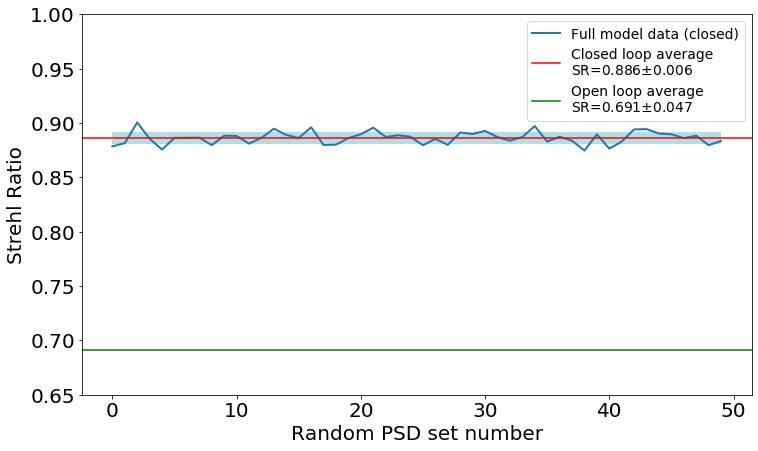

In [5]:
# Strehl
sr_closed = closed_data[0]
sr_mean = np.mean(sr_closed)
sr_std = np.std(sr_closed)
sr_open_avg = np.mean(open_data[0])
sr_open_std = np.std(open_data[0])
x = np.arange(tot_sets)

matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[12,7], facecolor='white')
plt.plot(x, sr_closed, linewidth=2,
         label='Full model data (closed)')
plt.axhline(sr_mean, color='r', #linewidth=0.75,
            label='Closed loop average\nSR={0:.3f}$\pm${1:.3f}'.format(sr_mean, sr_std))
plt.fill_between(x,sr_mean+sr_std,sr_mean-sr_std,
                 facecolor='powderblue', alpha=1.0, edgecolor='none')
plt.axhline(sr_open_avg, color='g', 
            label='Open loop average\nSR={0:.3f}$\pm${1:.3f}'.format(sr_open_avg, sr_open_std))
plt.ylim(top=1, bottom=0.65)
plt.xlabel('Random PSD set number')
plt.ylabel('Strehl Ratio')
#plt.title('Strehl ratio stats (allopd optics)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(loc='upper right', fontsize='x-small')
#plt.title('Strehl (all optics, thin spiders, calibrated psd)')

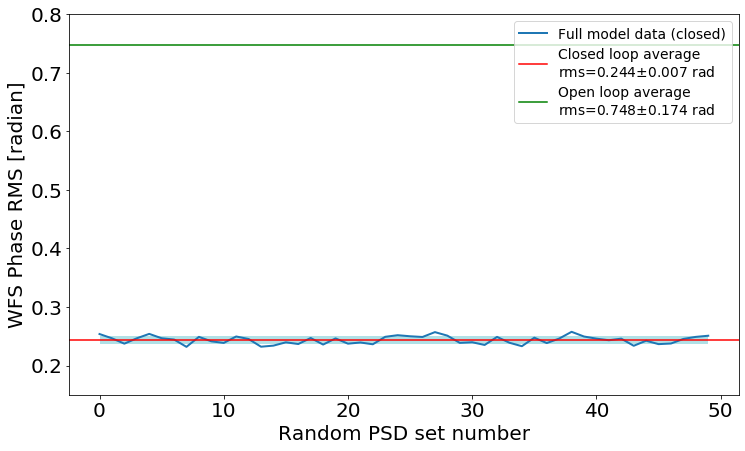

In [7]:
ph_closed = closed_data[1]
ph_mean = np.mean(ph_closed)
ph_std = np.std(ph_closed)
ph_open_avg = np.mean(open_data[1])
ph_open_std = np.std(open_data[1])
x = np.arange(tot_sets)

matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[12,7], facecolor='white')
plt.plot(x, ph_closed, linewidth=2,
         label='Full model data (closed)')
plt.axhline(ph_mean, color='r', #linewidth=0.75,
            label='Closed loop average\nrms={0:.3f}$\pm${1:.3f} rad'.format(ph_mean, ph_std))
plt.fill_between(x,ph_mean+ph_std,ph_mean-ph_std,
                 facecolor='powderblue', alpha=1.0, edgecolor='none')
plt.axhline(ph_open_avg, color='g', 
            label='Open loop average\nrms={0:.3f}$\pm${1:.3f} rad'.format(ph_open_avg, ph_open_std))
plt.ylim(top=0.8, bottom=0.15)
plt.xlabel('Random PSD set number')
plt.ylabel('WFS Phase RMS [radian]')
#plt.title('WFS Phase RMS stats (allopd optics)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(loc='upper right', fontsize='x-small')
#plt.title('WFS phase (all optics, thin spiders, calibrated psd)')

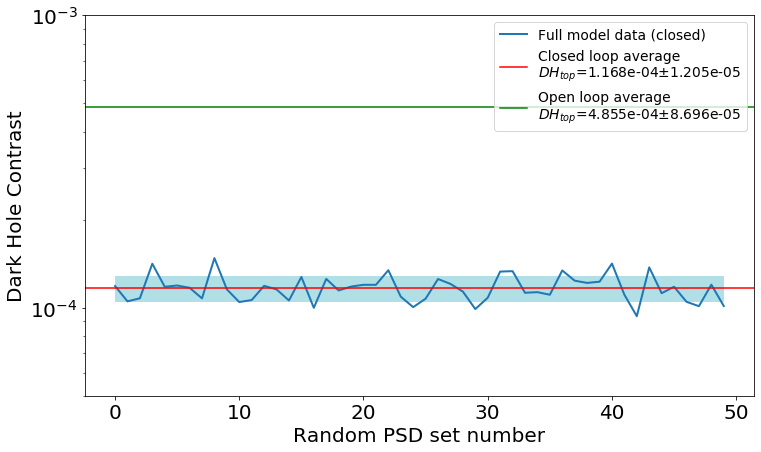

In [17]:
dh_top_closed = closed_data[2]
dh_top_mean = np.mean(dh_top_closed)
dh_top_std = np.std(dh_top_closed)
dh_top_open_avg = np.mean(open_data[2])
dh_top_open_std = np.std(open_data[2])
x = np.arange(tot_sets)

matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[12,7], facecolor='white')
plt.yscale('log')
plt.plot(x, dh_top_closed, linewidth=2,
         label='Full model data (closed)')
plt.axhline(dh_top_mean, color='r', #linewidth=0.75,
            label='Closed loop average\n{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{top}$',
                                                                        dh_top_mean, dh_top_std))
plt.fill_between(x,dh_top_mean+dh_top_std,dh_top_mean-dh_top_std,
                 facecolor='powderblue', alpha=1.0, edgecolor='none')
plt.axhline(dh_top_open_avg, color='g', 
            label='Open loop average\n{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{top}$',
                                                                      dh_top_open_avg, dh_top_open_std))
plt.ylim(top=1e-3, bottom=5e-5)
plt.xlabel('Random PSD set number')
plt.ylabel('Dark Hole Contrast')
#plt.title('Top DH stats (allopd optics)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(loc='upper right', fontsize='x-small')

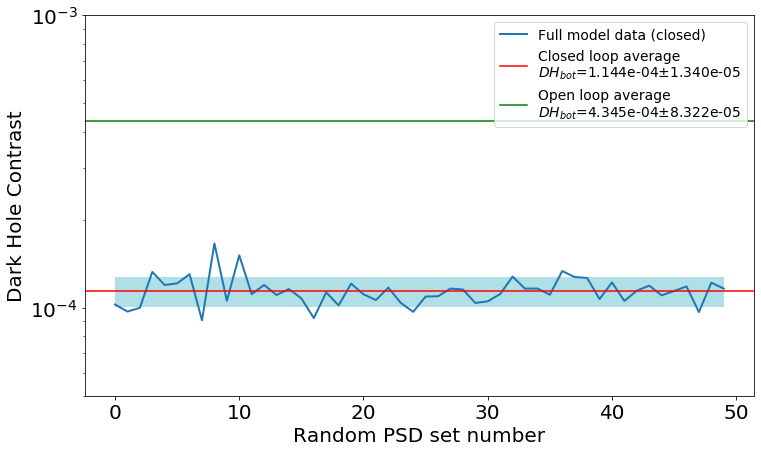

In [15]:
dh_bot_closed = closed_data[3]
dh_bot_mean = np.mean(dh_bot_closed)
dh_bot_std = np.std(dh_bot_closed)
dh_bot_open_avg = np.mean(open_data[3])
dh_bot_open_std = np.std(open_data[3])
x = np.arange(tot_sets)

matplotlib.rcParams["font.size"]=20
plt.figure(figsize=[12,7], facecolor='white')
plt.yscale('log')
plt.plot(x, dh_bot_closed, linewidth=2,
         label='Full model data (closed)')
plt.axhline(dh_bot_mean, color='r', #linewidth=0.75,
            label='Closed loop average\n{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{bot}$',
                                                                        dh_bot_mean, dh_bot_std))
plt.fill_between(x,dh_bot_mean+dh_bot_std,dh_bot_mean-dh_bot_std,
                 facecolor='powderblue', alpha=1.0, edgecolor='none')
plt.axhline(dh_bot_open_avg, color='g', 
            label='Open loop average\n{0}={1:.3e}$\pm${2:.3e}'.format(r'$DH_{bot}$',
                                                                      dh_bot_open_avg, dh_bot_open_std))
plt.ylim(top=1e-3, bottom=5e-5)
plt.xlabel('Random PSD set number')
plt.ylabel('Dark Hole Contrast')
#plt.title('Bot DH stats (allopd optics)')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.legend(loc='upper right', fontsize='x-small')